# Import Libraries

In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

PATH_DATASET = '../Dataset'
PATH_RESULTS = '../Results'

# Data Exploration

In [3]:
filename  = "international-airline-passengers.csv"
df = pd.read_csv(os.path.join(PATH_DATASET,filename))
df.columns = ["month","passengers"]
df.head()

,month,passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [4]:
df.tail()

,month,passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [5]:
df = df[:-1] # remove the last row
df.month = pd.to_datetime(df.month) # get the datetime
df.set_index("month",drop=True, inplace=True)
df.tail()

,passengers
month,
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0
1960-11-01,390.0
1960-12-01,432.0


<AxesSubplot:xlabel='month'>

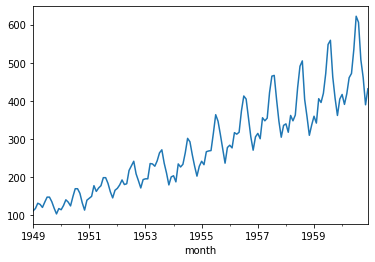

In [6]:
df["passengers"].plot()


# Data Loading - TimeSerie

In [7]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

In [8]:
# freq is monthly in our data

training_data = ListDataset(
    [{"start": df.index[0], "target": df.passengers[:"1958-12-01T00:00:00.000000"], }],
    freq = "M"
)

# Test data
## test data needs to contain both train and test data

test_data = ListDataset(
    [{"start": df.index[0], "target": df.passengers[:"1960-12-01T00:00:00.000000"]}],
    freq = "M"
)


/media/cristian/Extreme SSD/Investigacion/I2A2/TimeSeries/envubun/lib/python3.8/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/media/cristian/Extreme SSD/Investigacion/I2A2/TimeSeries/envubun/lib/python3.8/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/media/cristian/Extreme SSD/Investigacion/I2A2/TimeSeries/envubun/lib/python3.8/site-packages/gluonts/dataset/common.py:337: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return timestamp.freq.rollforward(timestamp)
/media/cristian/Extreme SSD/Investigacion/I2A2/TimeSeries/envubun/lib/python3.8/site-packages/gluonts/dataset/util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = 

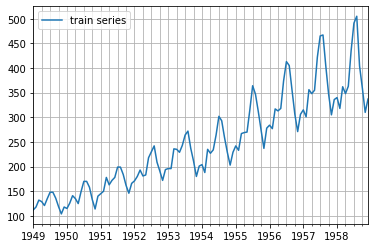

In [9]:
entry = next(iter(training_data))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
# plt.title(entry['item_id'])
plt.show()

/media/cristian/Extreme SSD/Investigacion/I2A2/TimeSeries/envubun/lib/python3.8/site-packages/gluonts/dataset/util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


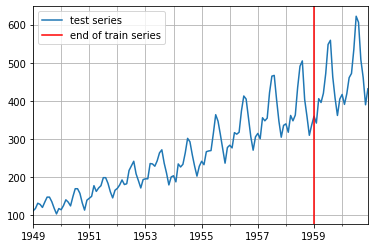

In [10]:
fig = plt.figure()
entry = next(iter(test_data))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(df.index[-24], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
# plt.title(entry['item_id'])
plt.show()

# Model

In [11]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

Few important parameters,

        context_length — The number of time-points that the model gets to see before making the prediction.
        prediction_length — The number of time-steps that the model is trained to predict, also called the forecast horizon.
        freq — The granularity of the time series in the dataset.
        num_cells — The number of cells to use in each hidden layer of the RNN.
        num_layers — The number of hidden layers in the RNN

In [12]:
callbacks = [
    LearningRateReduction(objective="min",
                          patience=10,
                          base_lr=1e-3,
                          decay_factor=0.5,
                          ),
    ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
]


estimator = DeepAREstimator(
    freq="M",
    prediction_length=24,
    context_length=36,
    num_layers = 2,
    num_cells = 40,
    distr_output=StudentTOutput(),
    dropout_rate=0.01,
    trainer=Trainer(#ctx = mx.context.gpu(),
                    epochs=10,
                    callbacks=callbacks))

predictor = estimator.train(training_data)

/media/cristian/Extreme SSD/Investigacion/I2A2/TimeSeries/envubun/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/media/cristian/Extreme SSD/Investigacion/I2A2/TimeSeries/envubun/lib/python3.8/site-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._min_time_point, self._max_time_point, freq=start.freq
  0%|          | 0/50 [00:00<?, ?it/s]/media/cristian/Extreme SSD/Investigacion/I2A2/TimeSeries/envubun/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/media/cristian/Extreme SSD/Investigacion/I2A2/TimeSeries/envubun/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is d

In [13]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [14]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

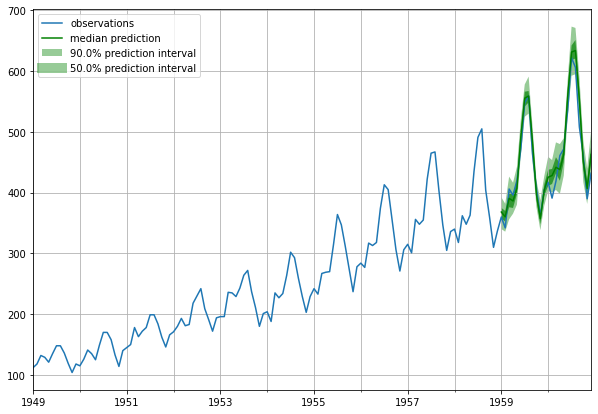

In [15]:
plot_prob_forecasts(ts_entry, forecast_entry)


In [25]:
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

agg_metrics = {k:'NaN' if v in [np.nan,None,''] else v  for k, v in agg_metrics.items()} # replace NaN in metrics

with open(os.path.join(PATH_RESULTS,'metrics.json'), 'w') as f:
    json.dump(agg_metrics, f)

print('RMSE',agg_metrics['RMSE'])

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 14.84it/s]/media/cristian/Extreme SSD/Investigacion/I2A2/TimeSeries/envubun/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq


RMSE 19.777508985047785


In [26]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 391.1498616536458,
    "abs_error": 389.10992431640625,
    "abs_target_sum": 10854.0,
    "abs_target_mean": 452.25,
    "seasonal_error": 28.574074074074073,
    "MASE": 0.5673994359766131,
    "MAPE": 0.03633382171392441,
    "sMAPE": 0.03570701430241267,
    "MSIS": 3.356984700309867,
    "QuantileLoss[0.1]": 157.160986328125,
    "Coverage[0.1]": 0.16666666666666666,
    "QuantileLoss[0.2]": 284.004150390625,
    "Coverage[0.2]": 0.4166666666666667,
    "QuantileLoss[0.3]": 354.1646484375,
    "Coverage[0.3]": 0.4166666666666667,
    "QuantileLoss[0.4]": 390.2616333007812,
    "Coverage[0.4]": 0.5833333333333334,
    "QuantileLoss[0.5]": 389.10992431640625,
    "Coverage[0.5]": 0.625,
    "QuantileLoss[0.6]": 364.247216796875,
    "Coverage[0.6]": 0.6666666666666666,
    "QuantileLoss[0.7]": 298.90988769531253,
    "Coverage[0.7]": 0.75,
    "QuantileLoss[0.8]": 244.75251464843745,
    "Coverage[0.8]": 0.9166666666666666,
    "QuantileLoss[0.9]": 153.85806274414057,
 